# Tutorial: fitting a FSRQ broad-band SED using angpy and sherpa

In this tutorial we will show how use `sherpa` to wrap `agnpy` functions to perform the fit of the broad-band SED of PKS1510-089, measured during its gamma-ray flaring activity in 2015 [(Ahnen et al. 2017)](https://ui.adsabs.harvard.edu/abs/2017A%26A...603A..29A/abstract). We select the MWL SED corresponding to the period identified in the paper as "Period B" (MJD 57164-57166). 

[sherpa](https://sherpa.readthedocs.io/en/latest/index.html) is required to run this notebook.

In [1]:
# import numpy, astropy and matplotlib for basic functionalities
import numpy as np
import astropy.units as u
from astropy.constants import c, G, k_B, m_e, M_sun
from astropy.coordinates import Distance
from pathlib import Path
from astropy.table import Table
import matplotlib.pyplot as plt
import pkg_resources

# import agnpy classes
import agnpy
from agnpy.emission_regions import Blob
from agnpy.spectra import ExpCutoffPowerLaw
from agnpy.synchrotron import Synchrotron
from agnpy.compton import SynchrotronSelfCompton, ExternalCompton
from agnpy.targets import RingDustTorus, SSDisk
from agnpy.utils.plot import load_mpl_rc, sed_x_label, sed_y_label, plot_sed

# import sherpa classes
from sherpa.models import model
from sherpa import data
from sherpa.fit import Fit
from sherpa.stats import Chi2
from sherpa.optmethods import LevMar

# constants
mec2 = m_e.to("erg", equivalencies=u.mass_energy())
gamma_size = 400
gamma_to_integrate = np.logspace(0, 7, gamma_size)

### `sherpa` wrapper of `agnpy` radiative processes
Now let us [follow the `sherpa` documentation](https://sherpa.readthedocs.io/en/latest/model_classes/usermodel.html) and define a model wrapping agnpy's functions to compute the Synchrotron, Synchrotron Self-Compton and External Compton on Dust Torus SEDs. We will assume a broken power-law electron distribution. The thermal SEDs of the Disk and the DT are added to the total flux model.

**NOTE:** for the parameters that vary over several orders of magnitude (i.e. normalisation and Lorentz factors of the electron distribution) it is better to provide to the fitting routine a "scaled" version of them (e.g. their log10), such that larger ranges might be covered with small parameters variation.

**NOTE:** the size of the blob $R_{\rm b}$ is constrained through the variability time scale, $t_{\rm var}$, and the Doppler factor, $\delta_{\rm D}$, via: $R_{\rm b} = (c t_{\rm var} \delta_{\rm D}) / (1 + z)$.

In [2]:
class AgnpyEC(model.RegriddableModel1D):
    """Wrapper of agnpy's non synchrotron, SSC and EC classes. The flux model
    accounts for the Disk and DT's thermal SEDs. 
    A broken power law is assumed for the electron spectrum.
    To limit the span of the parameters space, we fit the log10 of the parameters 
    whose range is expected to cover several orders of magnitudes (normalisation, 
    gammas, size and magnetic field of the blob). 
    """

    def __init__(self, name="ec"):

        # EED parameters
        self.log10_k_e = model.Parameter(name, "log10_k_e", -2.0, min=-20.0, max=10.0)
        self.p = model.Parameter(name, "p", 2.1, min=-2.0, max=5.0)
        self.log10_gamma_c = model.Parameter(name, "log10_gamma_c", 3, min=1, max=6)
        self.log10_gamma_min = model.Parameter(name, "log10_gamma_min", 1, min=0, max=4)
        self.log10_gamma_max = model.Parameter(name, "log10_gamma_max", 5, min=4, max=8)
        # source general parameters
        self.z = model.Parameter(name, "z", 0.1, min=0.01, max=1)
        self.d_L = model.Parameter(name, "d_L", 1e27, min=1e25, max=1e33, units="cm")
        # emission region parameters
        self.delta_D = model.Parameter(name, "delta_D", 10, min=0, max=40)
        self.log10_B = model.Parameter(name, "log10_B", -2, min=-4, max=2)
        self.t_var = model.Parameter(
            name, "t_var", 600, min=10, max=np.pi * 1e7, units="s"
        )
        self.mu_s = model.Parameter(name, "mu_s", 0.9, min=0.0, max=1.0)
        self.log10_r = model.Parameter(name, "log10_r", 17.0, min=16.0, max=20.0)
        # disk parameters
        self.log10_L_disk = model.Parameter(
            name, "log10_L_disk", 45.0, min=42.0, max=48.0
        )
        self.log10_M_BH = model.Parameter(name, "log10_M_BH", 42, min=32, max=45)
        self.m_dot = model.Parameter(
            name, "m_dot", 1e26, min=1e24, max=1e30, units="g s-1"
        )
        self.R_in = model.Parameter(name, "R_in", 1e14, min=1e12, max=1e16, units="cm")
        self.R_out = model.Parameter(
            name, "R_out", 1e17, min=1e12, max=1e19, units="cm"
        )
        # DT parameters
        self.xi_dt = model.Parameter(name, "xi_dt", 0.6, min=0.0, max=1.0)
        self.T_dt = model.Parameter(
            name, "T_dt", 1.0e3, min=1.0e2, max=1.0e4, units="K"
        )
        self.R_dt = model.Parameter(
            name, "R_dt", 2.5e18, min=1.0e17, max=1.0e19, units="cm"
        )

        model.RegriddableModel1D.__init__(
            self,
            name,
            (
                self.log10_k_e,
                self.p,
                self.log10_gamma_c,
                self.log10_gamma_min,
                self.log10_gamma_max,
                self.z,
                self.d_L,
                self.delta_D,
                self.log10_B,
                self.t_var,
                self.mu_s,
                self.log10_r,
                self.log10_L_disk,
                self.log10_M_BH,
                self.m_dot,
                self.R_in,
                self.R_out,
                self.xi_dt,
                self.T_dt,
                self.R_dt,
            ),
        )

    def calc(self, pars, x):
        """evaluate the model calling the agnpy functions"""
        (
            log10_k_e,
            p,
            log10_gamma_c,
            log10_gamma_min,
            log10_gamma_max,
            z,
            d_L,
            delta_D,
            log10_B,
            t_var,
            mu_s,
            log10_r,
            log10_L_disk,
            log10_M_BH,
            m_dot,
            R_in,
            R_out,
            xi_dt,
            T_dt,
            R_dt,
        ) = pars
        # add units, scale quantities
        x *= u.Hz
        k_e = 10 ** log10_k_e * u.Unit("cm-3")
        gamma_c = 10 ** log10_gamma_c
        gamma_min = 10 ** log10_gamma_min
        gamma_max = 10 ** log10_gamma_max
        B = 10 ** log10_B * u.G
        R_b = c.to_value("cm s-1") * t_var * delta_D / (1 + z) * u.cm
        r = 10 ** log10_r * u.cm
        d_L *= u.cm
        L_disk = 10 ** log10_L_disk * u.Unit("erg s-1")
        M_BH = 10 ** log10_M_BH * u.Unit("g")
        m_dot *= u.Unit("g s-1")
        R_in *= u.cm
        R_out *= u.cm
        R_dt *= u.cm
        T_dt *= u.K
        eps_dt = 2.7 * (k_B * T_dt / mec2).to_value("")

        # non-thermal components
        sed_synch = Synchrotron.evaluate_sed_flux(
            x,
            z,
            d_L,
            delta_D,
            B,
            R_b,
            ExpCutoffPowerLaw,
            k_e,
            p,
            gamma_c,
            gamma_min,
            gamma_max,
            ssa=True,
            gamma=gamma_to_integrate,
        )
        sed_ssc = SynchrotronSelfCompton.evaluate_sed_flux(
            x,
            z,
            d_L,
            delta_D,
            B,
            R_b,
            ExpCutoffPowerLaw,
            k_e,
            p,
            gamma_c,
            gamma_min,
            gamma_max,
            ssa=True,
            gamma=gamma_to_integrate,
        )
        sed_ec_dt = ExternalCompton.evaluate_sed_flux_dt(
            x,
            z,
            d_L,
            delta_D,
            mu_s,
            R_b,
            L_disk,
            xi_dt,
            eps_dt,
            R_dt,
            r,
            ExpCutoffPowerLaw,
            k_e,
            p,
            gamma_c,
            gamma_min,
            gamma_max,
            gamma=gamma_to_integrate,
        )
        # thermal components
        sed_bb_disk = SSDisk.evaluate_multi_T_bb_norm_sed(
            x, z, L_disk, M_BH, m_dot, R_in, R_out, d_L
        )
        sed_bb_dt = RingDustTorus.evaluate_bb_norm_sed(
            x, z, xi_dt * L_disk, T_dt, R_dt, d_L
        )
        return sed_synch + sed_ssc + sed_ec_dt + sed_bb_disk + sed_bb_dt

### Fitting with `sherpa`
Let us start here the procedure to fit with `sherpa`, first we read the data and then we pass them in a `Data1D` object provided by `sherpa`.     
We add an educated guess on systematic errors on the flux measurements in the different energy bands. 

In [3]:
# read the 1D data
sed_path = pkg_resources.resource_filename(
    "agnpy", "data/mwl_seds/PKS1510-089_2015b.ecsv"
)
sed_table = Table.read(sed_path)
x = sed_table["e_ref"].to("Hz", equivalencies=u.spectral())
y = sed_table["e2dnde"]
y_err_stat = sed_table["e2dnde_errn"]
# array of systematic errors, will just be summed in quadrature to the statistical error
# we assume
# - 30% on VHE gamma-ray instruments
# - 10% on HE gamma-ray instruments
# - 10% on X-ray instruments
# - 5% on lower-energy instruments
y_err_syst = np.zeros(len(x))
# define energy ranges
nu_vhe = (100 * u.GeV).to("Hz", equivalencies=u.spectral())
nu_he = (0.1 * u.GeV).to("Hz", equivalencies=u.spectral())
nu_x_ray_max = (300 * u.keV).to("Hz", equivalencies=u.spectral())
nu_x_ray_min = (0.3 * u.keV).to("Hz", equivalencies=u.spectral())
vhe_gamma = x >= nu_vhe
he_gamma = (x >= nu_he) * (x < nu_vhe)
x_ray = (x >= nu_x_ray_min) * (x < nu_x_ray_max)
uv_to_radio = x < nu_x_ray_min
# declare systematics
y_err_syst[vhe_gamma] = 0.30
y_err_syst[he_gamma] = 0.10
y_err_syst[x_ray] = 0.10
y_err_syst[uv_to_radio] = 0.05
y_err_syst = y * y_err_syst
# define the data1D object containing it
sed = data.Data1D("sed", x, y, staterror=y_err_stat, syserror=y_err_syst)

Now we create an instance of the model wrapping the non-thermal and thermal emissions.    
The parameters describing the electron distribution and the magnetic field are left free to vary.

In [4]:
# declare a model
agnpy_ec = AgnpyEC()
# global parameters of the blob and the DT
z = 0.361
d_L = Distance(z=z).to("cm")
# blob
Gamma = 20
delta_D = 25
Beta = np.sqrt(1 - 1 / np.power(Gamma, 2))  # jet relativistic speed
mu_s = (1 - 1 / (Gamma * delta_D)) / Beta  # viewing angle
B = 0.35 * u.G
# disk
L_disk = 6.7e45 * u.Unit("erg s-1")  # disk luminosity
M_BH = 5.71 * 1e7 * M_sun
eta = 1 / 12
m_dot = (L_disk / (eta * c ** 2)).to("g s-1")
R_g = ((G * M_BH) / c ** 2).to("cm")
R_in = 6 * R_g
R_out = 3e4 * R_g
# DT
xi_dt = 0.6  # fraction of disk luminosity reprocessed by the DT
T_dt = 2e3 * u.K
L_disk_45 = (L_disk / (1e45 * u.Unit("erg s-1"))).to_value("")
R_dt = 2.45 * 1e18 * np.sqrt(L_disk_45) * u.cm
# size and location of the emission region
t_var = 0.5 * u.d
r = 6e17 * u.cm

In [5]:
# instance of the model wrapping angpy functionalities
# - AGN parameters
# -- distances
agnpy_ec.z = z
agnpy_ec.z.freeze()
agnpy_ec.d_L = d_L.cgs.value
agnpy_ec.d_L.freeze()
# -- SS disk
agnpy_ec.log10_L_disk = np.log10(L_disk.to_value("erg s-1"))
agnpy_ec.log10_L_disk.freeze()
agnpy_ec.log10_M_BH = np.log10(M_BH.to_value("g"))
agnpy_ec.log10_M_BH.freeze()
agnpy_ec.m_dot = m_dot.to_value("g s-1")
agnpy_ec.m_dot.freeze()
agnpy_ec.R_in = R_in.to_value("cm")
agnpy_ec.R_in.freeze()
agnpy_ec.R_out = R_out.to_value("cm")
agnpy_ec.R_out.freeze()
# -- Dust Torus
agnpy_ec.xi_dt = xi_dt
agnpy_ec.xi_dt.freeze()
agnpy_ec.T_dt = T_dt.to_value("K")
agnpy_ec.T_dt.freeze()
agnpy_ec.R_dt = R_dt.to_value("cm")
agnpy_ec.R_dt.freeze()
# - blob parameters
agnpy_ec.delta_D = delta_D
#agnpy_ec.delta_D.freeze()
agnpy_ec.log10_B = np.log10(0.35)
agnpy_ec.mu_s = mu_s
agnpy_ec.mu_s.freeze()
agnpy_ec.t_var = (t_var).to_value("s")
agnpy_ec.t_var.freeze()
agnpy_ec.log10_r = np.log10(r.to_value("cm"))
agnpy_ec.log10_r.freeze()
# - EED
agnpy_ec.log10_k_e = np.log10(1e4)
agnpy_ec.p = 2.2
agnpy_ec.log10_gamma_c = np.log10(5e3)
agnpy_ec.log10_gamma_min = np.log10(1)
agnpy_ec.log10_gamma_min.freeze()
agnpy_ec.log10_gamma_max = np.log10(5e4)
agnpy_ec.log10_gamma_max.freeze()

In [6]:
agnpy_ec

<AgnpyEC model instance 'ec'>

Now we define the fit procedure choosing the statistics (chi2) and the minimisation method. We will fit only the data between $10^{11}\,{\rm Hz}$ and $10^{30}\,{\rm Hz}$, avoiding the lowest-energy radio data usually attributed to the extended jet emission.

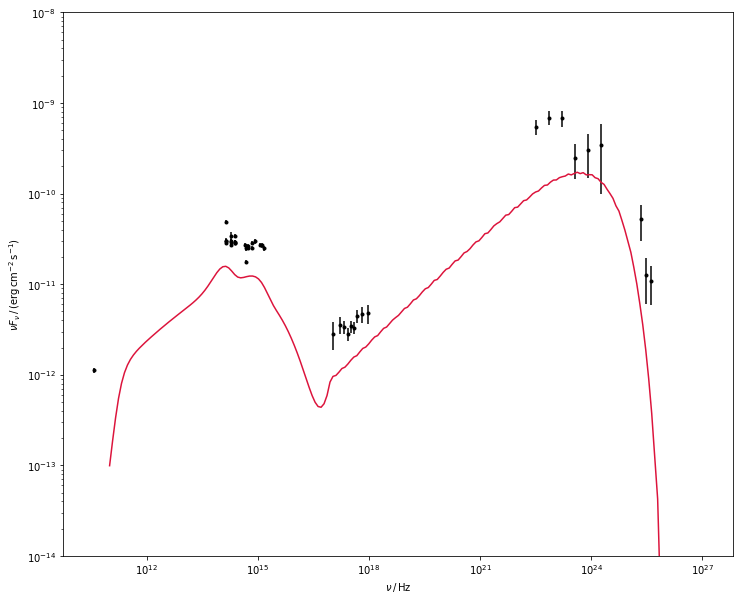

In [7]:
fig, ax = plt.subplots(figsize=(12, 10))
# plot the initial model
x = np.logspace(11, 27, 200)
plt.errorbar(sed.x, sed.y, yerr=sed.get_error(), marker=".", ls="", color="k")
plot_sed(x, agnpy_ec(x), ls="-", color="crimson")
plt.ylim([1e-14, 1e-8])
plt.show()

In [8]:
# fit using the Levenberg-Marquardt optimiser
fitter = Fit(sed, agnpy_ec, stat=Chi2(), method=LevMar())
min_x = 1e11 * u.Hz
max_x = 1e30 * u.Hz
sed.notice(min_x, max_x)

In [9]:
%%time
# perform the fit and time it!
results = fitter.fit()
print("-- fit succesful?", results.succeeded)
print(results.format())

-- fit succesful? True
Method                = levmar
Statistic             = chi2
Initial fit statistic = 2409.94
Final fit statistic   = 187.942 at function evaluation 143
Data points           = 41
Degrees of freedom    = 36
Probability [Q-value] = 1.83721e-22
Reduced statistic     = 5.22062
Change in statistic   = 2222
   ec.log10_k_e   4.72744      +/- 0.0938932   
   ec.p           1.84798      +/- 0.0488337   
   ec.log10_gamma_c   4.03589      +/- 0.0387006   
   ec.delta_D     14.1827      +/- 0.776499    
   ec.log10_B     -0.566527    +/- 0.048319    
CPU times: user 46.2 s, sys: 14.9 s, total: 1min 1s
Wall time: 1min 1s


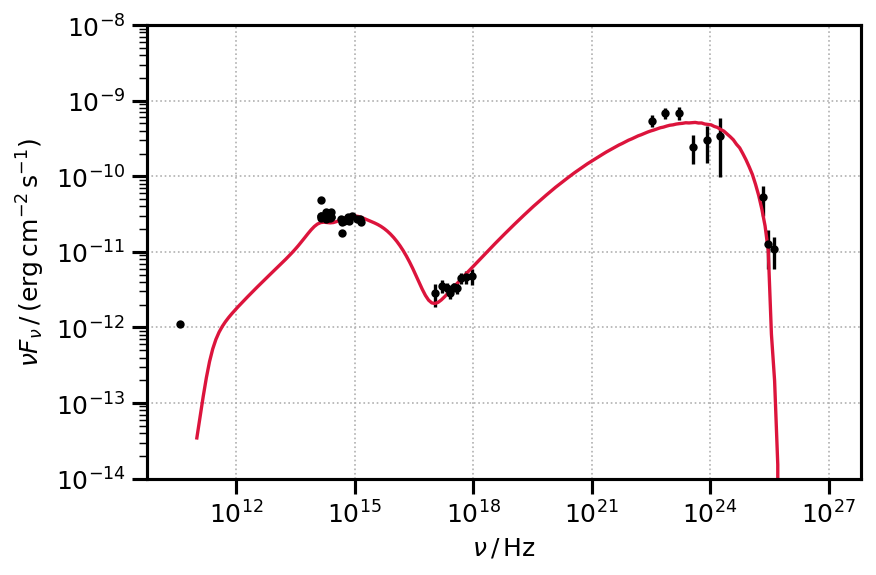

In [10]:
# plot the results!
load_mpl_rc()

x = np.logspace(11, 27, 200)
plt.errorbar(sed.x, sed.y, yerr=sed.get_error(), marker=".", ls="", color="k")
plot_sed(x, agnpy_ec(x), ls="-", color="crimson")
plt.ylim([1e-14, 1e-8])
plt.show()